In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

from scipy.io import savemat
from scipy.stats import ttest_rel, ttest_1samp, pearsonr, f_oneway, zscore
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data
from dn_utils.plotting import aligned_imshow_cbar

%matplotlib inline
mpl.rcParams['font.size'] = 13

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
path_derivatives = os.path.join(path_root, 'data/main_fmri_study/derivatives')
path_out = os.path.join(path_derivatives, 'ppi')
path_nistats = os.path.join(path_derivatives, 'nistats')
path_jags = os.path.join(path_derivatives, 'jags')
path_betamats = os.path.join(path_out, 'betamats')
path_parcellations = os.path.join(path_out, 'parcellations')
path_exclusion_csv = os.path.join(path_nistats, 'exclusion/exclusion.csv')
path_betamats_custom_roi = os.path.join(path_betamats, 'customROI')

# Behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=False)
n_subjects, n_conditions, n_trials, _ = beh.shape

# Behavioral modelling parameters
alpha_pdci_mle = np.load(os.path.join(
    path_jags, 
    'parameter_estimates/alpha_pdci_mle_3digits.npy'))
beta_pdci_mle = np.load(os.path.join(
    path_jags, 
    'parameter_estimates/beta_pdci_mle_3digits.npy'))

# PPI model regressors information
beta_names = ['physio', 'out_ons', 'out_perr', 'ppi_out_ons', 'ppi_out_perr', 
              'dec_ons', 'dec_wcor', 'res_lbp', 'res_rbp', 'out_off', 
              'reg_intercept']
n_regressors = len(beta_names)

# ROI information
df_custom = pd.read_csv(
    os.path.join(path_parcellations, 'custom_roi/custom_roi_table.csv'),
    sep=',')
n_rois = len(df_custom)
n_nets = len(df_custom['netName'].unique())

# Load exclusion table
df_exclusion = pd.read_csv(path_exclusion_csv, index_col=0)
ok_index = df_exclusion.index[df_exclusion['ok_all']]

---

In [3]:
t_event_psycho = 1
t_event_ppi = 1

beta_idx = beta_names.index('out_perr')
options = {
    'symmetrize': True,
    'zscore': True,
    'exclude_diagonal': True,
}

dirname_load = f'tpsycho-{int(t_event_psycho * 1000)}_tppi-{int(t_event_ppi * 1000)}'
print(dirname_load)

tpsycho-1000_tppi-1000


---

### Load beta matrices

Here, PPI matrices (each "connection" value is actually beta value for PPI GLM model, hence the name `beta_mats`) are loaded and aggregated over subjects and task conditions. Symmetrical version of matrices are created. These symmetrical version are then used to create average within and between subnetwork strenght matrices. 

- `beta_mats_agg`: beta_matrices (shape `n_regressors` $\times$ `n_rois` $\times$ `n_rois)` aggregated over subjects and tasks)
- `beta_mats_agg_trans`: version with beta weights symmetrized for connections `ij` and `ji` 
- `nets_mats_agg_trans`: connection strengths are averaged across subnetworks (↑pe network and ↓pe network)

In [4]:
def transform_connections(arr, fn):
    '''Transforms adjacency matrix into new one applying function fn to flat 
    vector of connection values. Diagonal remain unchanged.'''
    n = arr.shape[0]
    v = arr[np.triu_indices(n, k=1)]
    v = zscore(v)
    new = np.zeros((n, n))
    new[np.triu_indices(n, k=1)] = v
    new = new + new.T + np.diag(np.diag(arr))
    return new

In [5]:
beta_mats_agg = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_rois, n_rois))
beta_mats_agg_trans = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_rois, n_rois))
nets_mats_agg_trans = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_nets, n_nets))

for con, con_name in enumerate(meta['dim2']):
    for sub, sub_name in enumerate(meta['dim1']):
        
        beta_mats_fname = f'sub-{sub_name}_task-{con_name}_betamats.npy'
        beta_mats = np.load(os.path.join(path_betamats_custom_roi,
                                         dirname_load,
                                         beta_mats_fname))
        
        beta_mats_agg[sub, con] = beta_mats
        
        # Apply transformations
        beta_mats_trans = np.copy(beta_mats)
        if options['symmetrize']:
            beta_mats_trans = beta_mats_trans \
                            + np.transpose(beta_mats_trans, (0, 2, 1))
        if options['zscore']:
            for b, beta_mat_trans in enumerate(beta_mats_trans):
                beta_mats_trans[b] = transform_connections(beta_mat_trans, 
                                                           zscore)
        if options['exclude_diagonal']:
            for b in range(len(beta_mats_trans)):
                np.fill_diagonal(beta_mats_trans[b], val=np.nan)
        
        beta_mats_agg_trans[sub, con] = beta_mats_trans 
        
# Calculate network-level mean values (for transformed beta_mats)
for i, net_i in enumerate(df_custom['netName'].unique()):
    for j, net_j in enumerate(df_custom['netName'].unique()):
        net_i_idx = df_custom[df_custom['netName'] == net_i].index
        net_j_idx = df_custom[df_custom['netName'] == net_j].index
        nets_mats_agg_trans[:, :, :, i, j] = np.nanmean(
            beta_mats_agg_trans[:, :, :, net_i_idx, :][:, :, :, :, net_j_idx], 
            axis=(-1, -2))
        
# Filter excluded subjects
beta_mats_agg = beta_mats_agg[ok_index]
beta_mats_agg_trans = beta_mats_agg_trans[ok_index]
nets_mats_agg_trans = nets_mats_agg_trans[ok_index]
        
print('beta_mats_agg_trans.shape: ', beta_mats_agg_trans.shape)
print('nets_mats_agg_trans.shape: ', nets_mats_agg_trans.shape)

beta_mats_agg_trans.shape:  (29, 2, 11, 14, 14)
nets_mats_agg_trans.shape:  (29, 2, 11, 2, 2)


In [6]:
# Save to MATLAB file for further NBS use
nbs_beta_mats = np.concatenate((beta_mats_agg_trans[:, 0, beta_idx, :, :], 
                                beta_mats_agg_trans[:, 1, beta_idx, :, :]),
                               axis=0)
nbs_beta_mats = np.transpose(nbs_beta_mats, axes=[1, 2, 0])
savemat(os.path.join(path_betamats_custom_roi, dirname_load, 'nbs_betamats.mat'),
        {'nbs_beta_mats': nbs_beta_mats})
nbs_beta_mats.shape

(14, 14, 58)

## Question 1
---
Test whether within and between subnetworks strenght depends on subnetwork type and task condition.  

,sum_sq,df,F,PR(>F)
C(condition),2.149074e-10,1.0,3.039298e-09,9.999561e-01
C(net),9.398784e+01,2.0,6.646051e+02,1.593040e-80
C(condition):C(net),9.926892e-01,2.0,7.019486e+00,1.180789e-03
Residual,1.187920e+01,168.0,NaN,NaN


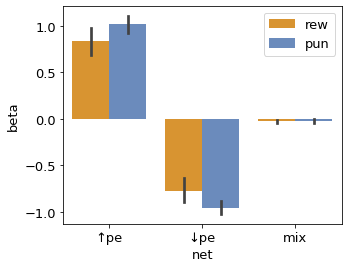

In [7]:
data = []
for sub, sub_name in enumerate(df_exclusion.loc[ok_index, 'sub']):
    for con, con_name in enumerate(meta['dim2']):
        for net, netidx in {'↑pe': (0, 0), '↓pe': (1, 1), 'mix': (1, 0)}.items():
            data.append(
                [
                    nets_mats_agg_trans[sub, con, beta_idx, netidx[0], netidx[1]],
                    sub_name,
                    con_name,
                    net
                ]
            )
            
df = pd.DataFrame(data, columns=['beta', 'sub_name', 'condition', 'net'])

# Two-way ANOVA
model = ols('beta ~ C(condition) + C(net) + C(condition):C(net)', data=df).fit()
df_anova = sm.stats.anova_lm(model, typ=2)

# Figure 
fig, ax = plt.subplots(figsize=(5, 4))
bp = sns.barplot(
    x='net', 
    y='beta', 
    hue='condition',
    data=df,
    ax=ax,
    palette={'rew': '#f49915', 'pun': '#5E88CA'}
)
plt.legend(loc='upper right')

df_anova

## Question 2
---
Comparison on the level of single connections

- Which connections significantly differ from 0 in reward condition?
- Which connections significantly differ from 0 in punishment condition?
- Which connections significantly differ between conditions?

In [8]:
beta_mat_neqzero_rew = np.zeros((3, n_rois, n_rois))
beta_mat_neqzero_pun = np.zeros((3, n_rois, n_rois))
beta_mat_rew_minus_pun = np.zeros((3, n_rois, n_rois))

triu_idx = np.triu_indices(n_rois, 1)

for i in range(n_rois):
    for j in range(n_rois):
        if i != j:
            
            beta_vec_rew = beta_mats_agg_trans[:, meta['dim2'].index('rew'), 
                                             beta_idx, i, j]
            beta_vec_pun = beta_mats_agg_trans[:, meta['dim2'].index('pun'), 
                                             beta_idx, i, j]

            beta_mat_neqzero_rew[:2, i, j] = np.array(
                ttest_1samp(beta_vec_rew, popmean=0))
            beta_mat_neqzero_pun[:2, i, j] = np.array(
                ttest_1samp(beta_vec_pun, popmean=0))
            beta_mat_rew_minus_pun[:2, i, j] = np.array(
                ttest_1samp(beta_vec_rew - beta_vec_pun, popmean=0))
        
# Correct for multiple comparisons
beta_mat_neqzero_rew[2][triu_idx] = multipletests(
    beta_mat_neqzero_rew[1][triu_idx], alpha=0.05, method='fdr_bh')[1]
beta_mat_neqzero_pun[2][triu_idx] = multipletests(
    beta_mat_neqzero_pun[1][triu_idx], alpha=0.05, method='fdr_bh')[1]
beta_mat_rew_minus_pun[2][triu_idx] = multipletests(
    beta_mat_rew_minus_pun[1][triu_idx], alpha=0.05, method='fdr_bh')[1]

beta_mat_neqzero_rew[2] = beta_mat_neqzero_rew[2] + beta_mat_neqzero_rew[2].T 
beta_mat_neqzero_pun[2] = beta_mat_neqzero_pun[2] + beta_mat_neqzero_pun[2].T 
beta_mat_rew_minus_pun[2] = beta_mat_rew_minus_pun[2] \
                          + beta_mat_rew_minus_pun[2].T 

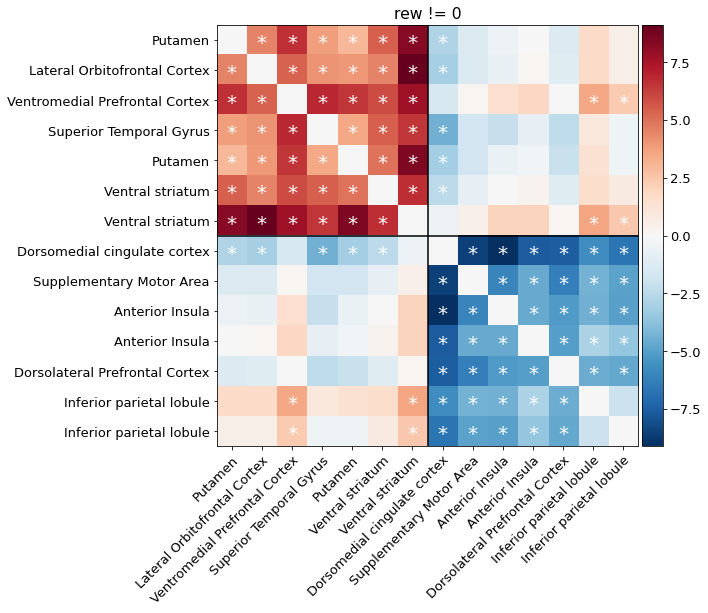

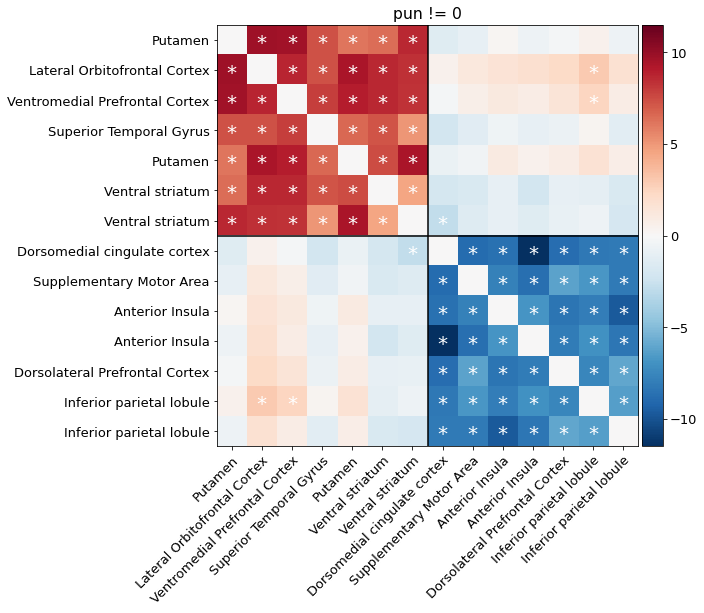

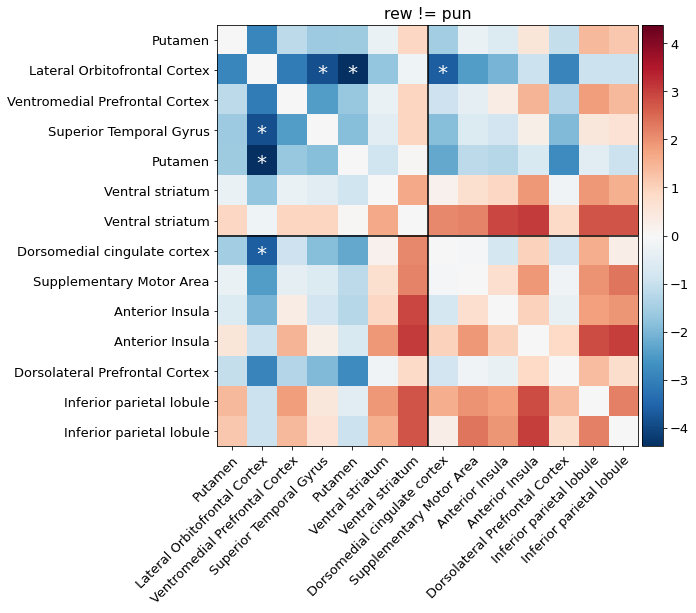

In [9]:
for corr_mat, effect_name in zip(
    (beta_mat_neqzero_rew, beta_mat_neqzero_pun, beta_mat_rew_minus_pun), 
    ('rew != 0', 'pun != 0', 'rew != pun')
):

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(
        #corr_mat[0] * (corr_mat[1] < 0.05),
        corr_mat[0],
        cmap='RdBu_r'
    )

    ax.set_xticks(np.arange(n_rois))
    ax.set_yticks(np.arange(n_rois))
    ax.set_xticklabels(df_custom['Regions'])
    ax.set_yticklabels(df_custom['Regions'])
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')

    # Colorbar
    im.set_clim([-max(np.abs(im.get_clim())), max(np.abs(im.get_clim()))])
    aligned_imshow_cbar(ax, im)

    # Add FDR corrected significance
    for i,j in zip(*np.nonzero(corr_mat[2] < 0.05)):
        if i != j:
            ax.text(j, i+0.1, '*', ha='center', va='center', color='w', fontSize=20)

    # Separate networks
    ax.axvline(6.5, color='k')
    ax.axhline(6.5, color='k')
    ax.set_title(effect_name)

## Question 3
---
Does change in connectivity between right and left VS and vmPFC correlates with difference in learning rates?

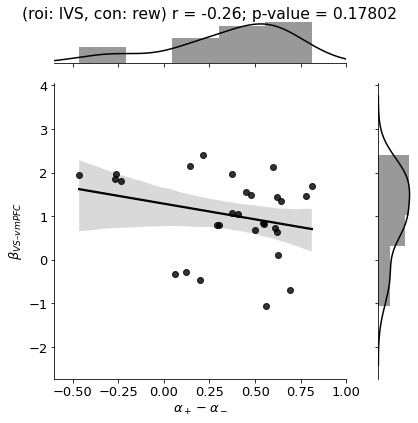

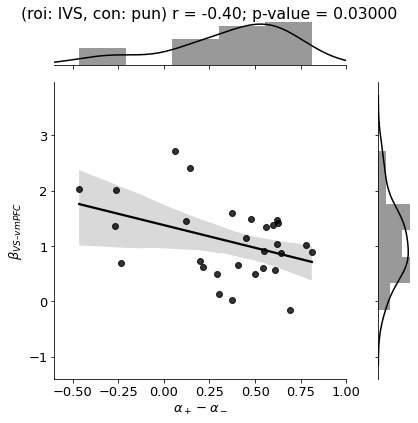

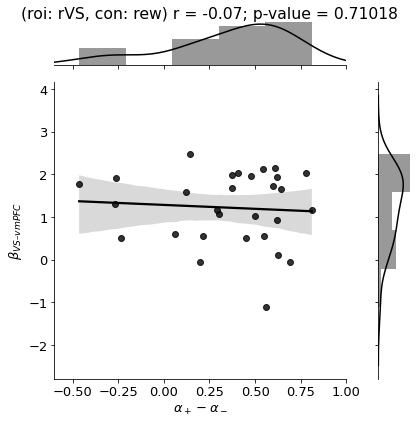

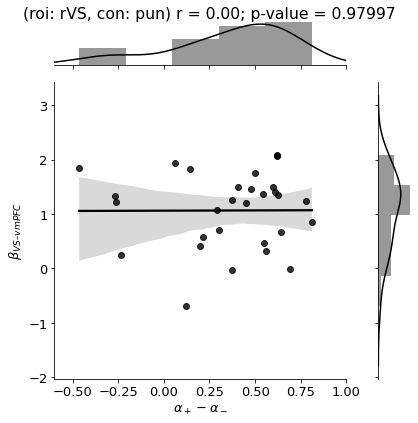

In [10]:
idx_vmpfc = (df_custom['Regions'] == 'Ventromedial Prefrontal Cortex').argmax()
idx_vs_r = ((df_custom['Regions'] == 'Ventral striatum') \
          & (df_custom['Hemisphere'] == 'R')).argmax()
idx_vs_l = ((df_custom['Regions'] == 'Ventral striatum') \
          & (df_custom['Hemisphere'] == 'L')).argmax()


for roi_idx, roi_name in zip((idx_vs_l, idx_vs_r), ('lVS', 'rVS')):
    for con, con_name in enumerate(meta['dim2']):

        vec_beh = alpha_pdci_mle[ok_index, 0] - alpha_pdci_mle[ok_index, 1] 
        vec_net = beta_mats_agg_trans[:, con, beta_idx, idx_vmpfc, roi_idx] 

        ax = sns.jointplot(
            vec_beh, 
            vec_net, 
            kind='reg',
            xlim=[-0.6, 1],
            color='k', 
        )
        plt.xlabel(r'$\alpha_+ - \alpha_-$')
        plt.ylabel(r'$\beta_{VS – vmPFC}$')
        ax.fig.suptitle('(roi: {}, con: {}) r = {:.2f}; p-value = {:.5f}'.format(
            roi_name, con_name, *pearsonr(vec_beh, vec_net)))
        ax.fig.tight_layout()
        ax.fig.subplots_adjust(top=0.95) # Reduce plot to make room 